# Cosmic Ray Impacts on Turbulence

#### Relevant publication #1: Bustard and Oh 2023, "Cosmic Ray Drag and Damping of Compressive Turbulence"
#### Link: https://iopscience.iop.org/article/10.3847/1538-4357/aceef9

#### Relevant publication #2: Bustard and Oh 2022, "Turbulent Reacceleration of Streaming Cosmic Rays"
#### Link: https://iopscience.iop.org/article/10.3847/1538-4357/aca021

------------------------------------------------------------------------------------------------
### Aim: 
This notebook shows a subset of the Python code and analysis done in the above papers, which aim to better understand the interplay between cosmic rays and their magnetized, turbulent environments. 

### Data:
Data products were generated by running a suite of turbulence simulations using a version of the Athena++ magnetohydrodynamics (MHD) code modified to include cosmic rays (CRs) as a relativistic fluid in addition to normal, non-relativistic gas. The suite comprises terabytes of 3D simulation volumes with varying cosmic ray transport properties (cosmic ray streaming, diffusion, advection, etc.) and varying ratios of cosmic ray pressure $P_{\rm CR}$, gas pressure $P_{\rm g}$, and magnetic pressure $P_{\rm B}$.

### Background: 
Astrophysical environments are turbulent, with gas, magnetic fields, and cosmic rays constantly being compressed (by compressive turbulence) and swirled around (by solenoidal turbulence). In this application, it's helpful to think of MHD turbulence as an ensemble of waves that interact with each other and with cosmic rays. How cosmic rays interact with waves is quite analogous to harmonic oscillators from intro physics: depending on cosmic ray transport and local gas conditions, cosmic rays can either act as a damping term where they take energy from the fluctuating waves or as an excitation term where they can give energy to the waves and drive instabilities. These physical processes have been studied in 1D idealized simulations but never before in fully 3D, turbulent simulations with a self-consistent, fluid treatment of cosmic ray streaming. In Bustard and Oh 2022, we focus on how cosmic rays gain energy from turbulence, taking into account cosmic ray streaming, and in Bustard and Oh 2023, we focus on how that energy transfer affects turbulence. 

The following video shows the ratio of CR pressure to gas pressure in a turbulence simulation. You'll see a lot of sloshing motions and very little swirling motions because I'm driving turbulence in a purely compressive way. 

------------------------------------------------------------------------------------------------

In [4]:
# Load important libraries
import yt
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

from IPython.display import Video

Video("figures/Pcr_Pg.mp4",embed = True)

Let's jump into some specific analysis of these simulations, focusing first on how CRs gain energy from turbulence.

## Energy growth rates: Time-series analysis

At set time intervals, the simulation outputs integrated quantities such as kinetic energy, magnetic energy, and cosmic ray energy stored in a file called cr.hst. We'll use one of these files and rolling averages to find the exponential growth rate of CR energy as a function of time. We can then compare that to the turbulent stirring rate (a constant that is set by the user)



In [5]:
# Load in integrated quantities from Athena++ history data file

dir = './files/'

time, mass, ke1, ke2, ke3, me1, me2, me3, ec = np.loadtxt(dir+'cr.hst',skiprows = 2, usecols = (0,2,6,7,8,9,10,11,12),unpack=True)


# Alfven Mach number M_A = v/v_A
alfvenMach = np.sqrt(2*(ke1 + ke2 + ke3)/(mass))/np.sqrt(2*(me1+me2+me3)/(mass))

edenstocgs = 6.54e-11 # conversion of energy density in code units to physical units (CGS)
cellVol1 = (2.0)**3.0

# arrays to store velocity, sound speed, kinetic energy, magnetic energy, thermal energy, and CR energy
vval = []
csval = []
ketot = []
metot = []
thermaletot = []
ectot = []

for j in range(0,len(time),1):
  keval = (ke1[j] + ke2[j] + ke3[j])*edenstocgs/cellVol1
  ketot.append(keval)
  meval = (me1[j] + me2[j] + me3[j])*edenstocgs/cellVol1
  cs2 = (.11*1e8)**2.0 # hard-coded using input sound speed of 0.11 in code units
  csval.append(np.sqrt(cs2))
  ecval = ec[j]*edenstocgs/cellVol1
  vval.append((np.sqrt(2*(ke1[j] + ke2[j] + ke3[j])/(mass[j])) * 1.e8))
  metot.append(meval)
  ectot.append(ecval)

Let's start by doing a rough calculation of the average cosmic ray energy growth rate. Under the right conditions, this can be very fast! In this case, conditions for fast cosmic ray growth are not optimal, but cosmic rays do soak up a large fraction of the input energy

In [7]:
# Start by getting a preliminary estimate of the (exponential) CR energy growth rate
print("Number of time snapshots: " + str(len(ectot)))

# Change these to get slope between different start and end points
start = int(len(ectot)/4.)
end = int(3.*len(ectot)/4.)

# Note we take the log of ectot because we want the exponential growth rate, i.e. convert an exponential curve
# to a linear curve and then find the slope
p0 = np.polyfit(time[start:end],np.log10(np.array(ectot[start:end])),1)
growthTime_log = (1/(p0[0]*np.log(10)))


# v_ph ~ c_s = 1e7 for CGM
print("L*v_ph = {}".format(3.0856e21*1e7))
print("Simulation growth time (Myrs) = {}".format(growthTime_log))

Number of time snapshots: 6986
L*v_ph = 3.0856e+28
Simulation growth time (Myrs) = 1198.4721011637334


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


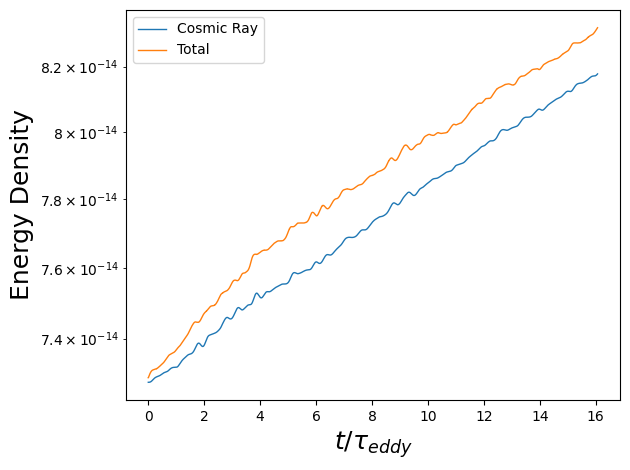

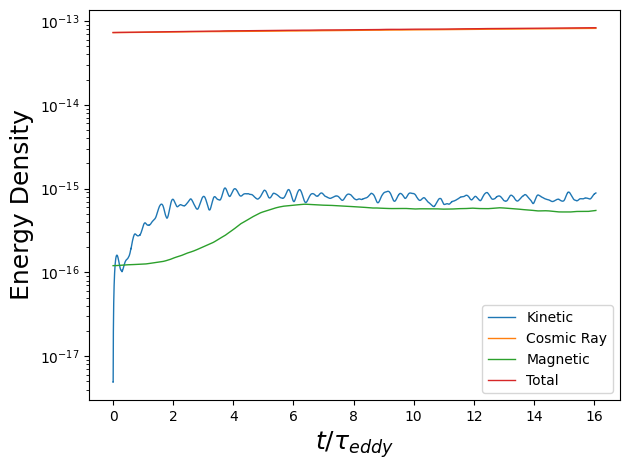

In [34]:
# Calculating CR pressure / gas pressure and time / eddy turnover time
CRPresGasPres = np.array(ectot)*0.333/(1.67e-28*1e14)
timeeddy = np.array(time)*3.155e13/(0.667*3.0856e21/7.5e6)


plt.semilogy(timeeddy,alfvenMach,linewidth=1)
plt.xlabel(r'$t/ \tau_{eddy}$',fontsize=18)
plt.ylabel('M_A',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(dir+'alfvenMach.pdf')
plt.close()

plt.semilogy(timeeddy,vval,linewidth=1)
plt.xlabel(r'$t/ \tau_{eddy}$',fontsize=18)
plt.ylabel('Average Velocity (cm/s)',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(dir+'Velocity.pdf')
plt.close()

plt.semilogy(timeeddy,CRPresGasPres,linewidth=2)
plt.xlabel(r'$t/ \tau_{eddy}$',fontsize=18)
plt.ylabel(r'$P_{CR}/P_{g}$',fontsize=18)
#plt.legend()
plt.tight_layout()
plt.savefig(dir+'CRPresGasPres.pdf')
plt.close()

#plt.semilogy(timeeddy,ketot,linewidth=1,label="Kinetic")
plt.semilogy(timeeddy,ectot,linewidth=1,label="Cosmic Ray")
#plt.semilogy(timeeddy,metot,linewidth=1,label="Magnetic")
plt.semilogy(timeeddy,np.array(metot) + np.array(ectot) + np.array(ketot),linewidth=1,label="Total")
plt.xlabel(r'$t/ \tau_{eddy}$',fontsize=18)
plt.ylabel('Energy Density',fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()

plt.semilogy(timeeddy,ketot,linewidth=1,label="Kinetic")
plt.semilogy(timeeddy,ectot,linewidth=1,label="Cosmic Ray")
plt.semilogy(timeeddy,metot,linewidth=1,label="Magnetic")
plt.semilogy(timeeddy,np.array(metot) + np.array(ectot) + np.array(ketot),linewidth=1,label="Total")
plt.xlabel(r'$t/ \tau_{eddy}$',fontsize=18)
plt.ylabel('Energy Density',fontsize=18)
plt.legend()
plt.tight_layout()
plt.savefig(dir+'EnergyDensities.pdf')
plt.show()
plt.close()

Both figures show time on the x-axis and the log of energies on the y-axis. The top figure shows that cosmic ray energy is a large fraction of the total energy quantified (cosmic ray + magnetic + kinetic), while the bottom figure shows that magnetic energy and kinetic energy are quite subdominant.

Next, let's quantify the energy growth rates of each component (cosmic rays, magnetic fields, kinetic motions) and compare them to the total energy input rate

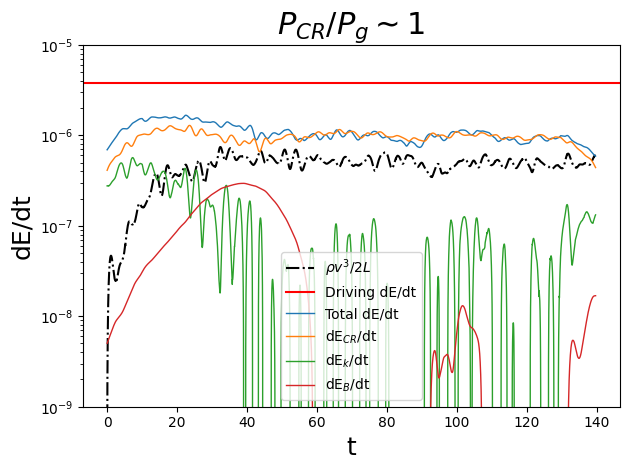

In [35]:
# Calculate rolling derivatives of quantities
def get_deriv(y,x,smooth = None):
    """Return derivative of `y` wrt to `x`
     while keeping the length constant.
      Keywords:
     * hst           -- HST numpy array
       * y          -- other y values or key to take the derivate
       * x          -- key
       * smooth        -- smooth over length in units of `x`
     """

    dx = (x[1:] - x[:-1])
    dydx = (y[1:] - y[:-1]) / dx
    if smooth is not None:
        if isinstance(smooth, int):
            n = smooth
        else:
            n = np.round(smooth / np.median(dx))
        dydx = np.convolve(dydx, np.ones(int(n)) / n, mode='same')

    r = np.interp(x, 0.5 * (x[1:] + x[:-1]), dydx)
    return r

# Set smoothing length
smooth = 1000


totE_codeunits = (np.array(metot) + np.array(ectot) + np.array(ketot))/edenstocgs

# rho*v^3/2L is a useful quantity to know -- in hydrodynamic turbulence, this is equal to
# the input driving energy, and deviations from this relationship tell us the impact of 
# magnetic fields and cosmic rays
rhov3L = .03066*((np.array(vval)/1e8)**3.0)/(2.0*0.667)

plt.plot(time,rhov3L,'k-.',label=r"$\rho v^{3} / 2L$")
plt.axhline(y=3e-5/cellVol1, color='r', linestyle='-',label="Driving dE/dt")
plt.semilogy(time,get_deriv(totE_codeunits,time,smooth=smooth),linewidth=1,label="Total dE/dt")
plt.semilogy(time,get_deriv(np.array(ectot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{CR}$/dt")
plt.semilogy(time,get_deriv(np.array(ketot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{k}$/dt")
plt.semilogy(time,get_deriv(np.array(metot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{B}$/dt")
plt.ylim(1e-9,1e-5)
plt.xlabel(r't',fontsize=18)
plt.ylabel('dE/dt',fontsize=18)
plt.title(r"$P_{CR}/P_{g} \sim 1$",fontsize=22)
plt.legend()
plt.tight_layout()
plt.savefig(dir+'dEdt_codeunits_log.pdf')
plt.show()
plt.close()

plt.plot(time,rhov3L,'k-.',label=r"$\rho v^{3} / 2L$")
plt.axhline(y=3e-5/cellVol1, color='r', linestyle='-',label="Driving dE/dt")
plt.plot(time,get_deriv(totE_codeunits,time,smooth=smooth),linewidth=1,label="Total dE/dt")
plt.plot(time,get_deriv(np.array(ectot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{CR}$/dt")
plt.plot(time,get_deriv(np.array(ketot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{k}$/dt")
plt.plot(time,get_deriv(np.array(metot)/edenstocgs,time,smooth=smooth),linewidth=1,label=r"dE$_{B}$/dt")
plt.ylim(1e-8,1e-5)
plt.xlabel(r't',fontsize=18)
plt.ylabel('dE/dt',fontsize=18)
plt.title(r"$P_{CR}/P_{g} \sim 1$",fontsize=22)
plt.legend()
plt.tight_layout()
plt.savefig(dir+'dEdt_codeunits_nolog.pdf')
#plt.show()
plt.close()

You'll notice that neither the total dE/dt nor rhov^3/2L add up to the horizontal red line (the constant energy input rate)! This is because we are only quantifying the ups and downs of magnetic energy, cosmic ray energy, and kinetic energy, NOT including any energy that is lost from the system due to cosmic ray energy loss -- because the gas is isothermal, this energy is completely lost from the simulation instead of being put back into the system in the form of heat. 

Let's quickly quantify the average energy gain rates at late times (when they have more-or-less stabilized) before we additionally quantify the amount of energy lost from the system due to cosmic ray "interception".

In [20]:
# Calculate fractions of input energy that go into CRs, etc.

eps = (3e-5/cellVol1) # energy input rate in code units

# dEc/dt in code units
ecderiv = get_deriv(np.array(ectot)/edenstocgs,time,smooth=smooth)

# dEtot/dt in code units
totederiv = get_deriv(np.array(totE_codeunits),time,smooth=smooth)
print(r"f_{CR} =  " + str(np.mean(ecderiv[int(3*len(ecderiv)/4):len(ecderiv)-1])/eps))
print(r"f_{E} =  " + str(np.mean(rhov3L[int(3*len(ecderiv)/4):len(ecderiv)-1])/eps))
print(r"f_{tot} = " + str(np.mean(totederiv[int(3*len(totederiv)/4):len(totederiv)-1])/eps))

f_{CR} =  0.2374729535746033
f_{E} =  0.13176189294429297
f_{tot} = 0.24147444502707388


Most notably, note f_E, which is the ratio of rho v^3/2L to epsilon, the energy input rate. In hydrodynamic turbulence, this is equal to 1, but here, in the presence of cosmic rays, it only reaches 0.13, a massive decrease!

## Quantifying energy partitions
Now, we'll plot the outcome of energy input into many simulations, particularly taking into account the 
energy gain by the cosmic rays, the rate of energy lost by the cosmic rays, AND the remaining rate of energy dissipation at 
the grid scale (the traditional energy outcome when cosmic rays aren't present). We'll see that cosmic rays change things quite dramatically from what happens in hydrodynamic turbulence, where energy dissipation is close to 100% of the energy budget...

Separate scripts were used to calculate these energy gain/loss rates, and average values were tabulated in turbulent_energy_partitions.csv

In [21]:
# Import data from CSV file
import pandas as pd

df = pd.read_csv('files/turbulent_energy_partitions.csv')


# this data is in wide form, but it's easier to work with in long form
df = df.to_numpy()
df = df.flatten('F')

# This is kind of gross, but it works for now to help label the chart correctly
dfall = pd.DataFrame(dict(
    beta = [r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 1$',r'$\beta \sim 10$',
    r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',r'$\beta \sim 10$',
    r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$',r'$\beta \sim 100$'],
    labels = ["Diffusion Only","Diffusion Only","Diffusion Only","Streaming Only","Streaming Only","Streaming Only","Diff + Stream","Diff + Stream","Diff + Stream","Adiab. Stream Only","Adiab. Stream Only","Adiab. Stream Only","Adiab. Diff + Stream","Adiab. Diff + Stream","Adiab. Diff + Stream"] * 3,
    flabel = [r'$f_{\rm CR} \text{, CR Energization}$', r'$f_{\rm CR, heating} \text{, Streaming Energy Loss}$', r'$f_{\rm th} - f_{\rm CR, heating} \text{, Grid-Scale Heating}$'] * 15,
    f = df))

#Take a look at the dataframe
print(dfall.head(16))


##########################################################################3
# Now comes the fun part of plotting this as a stacked, grouped bar chart. After trying
# some methods in regular matplotlib, seaborn, etc., plotly emerged as the best option

# Without this ridiculous work-around, every PDF file I save has a box with "Loading MathJax" written in the lower left corner. 
# Might be a problem with the Kaleido package used to write plotly images to files
# For now, I'll omit this and let the LaTeX stuff be rendered incorrectly

#figure="some_figure.pdf"
#fig=px.scatter(x=[0, 1, 2, 3, 4], y=[0, 1, 4, 9, 16])
#fig.write_image(figure, format="pdf")

#time.sleep(2) # this delay gives some time for MathJax to load before the next figure (the real figure) is plotted and saved

fig = go.Figure()


# Note that all text that includes LaTeX anywhere near it has to be inside $ $
fig.update_layout(
    template="simple_white",
    xaxis=dict(ticklen=0),
    yaxis=dict(title_text=r"$\dot{E}/\epsilon$",range=(0,1.1)),
    font=dict(size=12),
    barmode="stack",
    legend=dict(
        font=dict(size=12),
        x=0.55,
        y=1.4,
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(255, 255, 255, 0)'
    )
)

colors = ["blue", "red","orange"]

# Add traces for each bar. Grouped by $\beta \sim ...$, colored by f_{CR} or f_{CR, heating}
for r, c in zip(dfall.flabel.unique(), colors):
    plot_df = dfall[dfall.flabel == r]
    fig.add_trace(
        go.Bar(x=[plot_df.beta, plot_df.labels], y=plot_df.f, name=r, marker_color=c,opacity=0.7),
    )
fig.update_xaxes(
        tickangle = 90,
        tickson = "boundaries",
        ticks="inside",
        ticklen=0, # just get rid of the ticks
        dividerwidth=0,
        dividercolor='black',
        title_text = r"", # just get rid of the title
        title_font = {"size": 10},
        title_standoff = 20)

# To write to PDF
#fig.write_image("barchart_plotly.pdf",engine="kaleido")
#fig.show() #-- Since the LateX labels might not be rendered correctly
            #  depending on the platform this is being run on (see all the funny workarounds above),
            # I've commented this part out and just added the figure from our paper in the next cell

               beta                labels  \
0    $\beta \sim 1$        Diffusion Only   
1    $\beta \sim 1$        Diffusion Only   
2    $\beta \sim 1$        Diffusion Only   
3    $\beta \sim 1$        Streaming Only   
4    $\beta \sim 1$        Streaming Only   
5    $\beta \sim 1$        Streaming Only   
6    $\beta \sim 1$         Diff + Stream   
7    $\beta \sim 1$         Diff + Stream   
8    $\beta \sim 1$         Diff + Stream   
9    $\beta \sim 1$    Adiab. Stream Only   
10   $\beta \sim 1$    Adiab. Stream Only   
11   $\beta \sim 1$    Adiab. Stream Only   
12   $\beta \sim 1$  Adiab. Diff + Stream   
13   $\beta \sim 1$  Adiab. Diff + Stream   
14   $\beta \sim 1$  Adiab. Diff + Stream   
15  $\beta \sim 10$        Diffusion Only   

                                               flabel       f  
0               $f_{\rm CR} \text{, CR Energization}$  0.8600  
1   $f_{\rm CR, heating} \text{, Streaming Energy ...  0.0000  
2   $f_{\rm th} - f_{\rm CR, heating} \tex

The above figure might not render LaTeX correctly; below, I load in the full figure (and caption) from our paper.

(-0.5, 1951.5, 1499.5, -0.5)

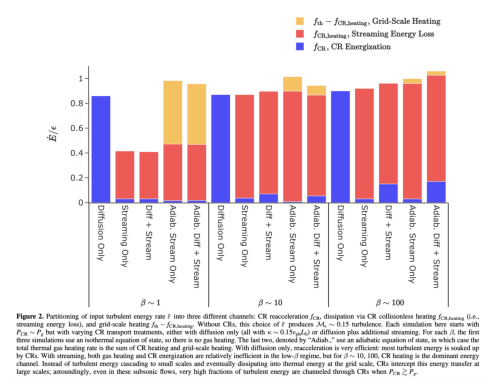

In [22]:
image_path = "figures/BustardOh2023_fig2.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

What we see is that "grid scale heating", i.e. the traditional outcome of energy, is only a very small portion of the energy budget. In fact,
for high $\beta$ values, it comprises only a few percent; instead of energy being dissipated at the grid scale, where it heats the background
gas, heating actually comes from the cosmic rays at very different scales. In some cases, namely when cosmic ray transport is diffusion only, that energy instead goes into the cosmic ray population. 

In either case, cosmic rays are intercepting the turbulent cascade and affecting the scale and amount of heating that the gas receives. 

## Calculating turbulence energy spectra

With such large portions of the turbulent driving energy going either towards CR energization or CR heating rather than grid-scale heating, it's likely that turbulent properties, such as the amount of power in velocity fluctuations on each scale, will change significantly. This is indeed the case. 

To calculate the amount of power on each scale, we take the Fourier transform using numpy as follows. First, we define a helper function that will take the Fourier transform of $\rho^{1/2} v$ and return the power, i.e. in units of $\rho v^{2}$, what we need for kinetic energy. 

In [23]:
# Full version that takes in multiple fields (irho, iu) and additional input nindex_rho
def fft_comp_withrho(ds, irho, iu, nindex_rho, level, low, delta ):

    # FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this in general, which allows this script to run on 
    # simulation grids with non-uniform resolution. In this specific application,
    # our grid is already uniform so this next line is overkill.
    cube = ds.covering_grid(level, left_edge=low,
                            dims=delta,
                            fields=[irho, iu])

    rho = cube[irho].d
    u = cube[iu].d

    nx, ny, nz = rho.shape

    # Take FFT of rho^nindex_rho x u -- for kinetic energy, nindex_rho should = 1/2
    ru = np.fft.fftn(rho**nindex_rho * u)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ru = 8.0*ru/(nx*ny*nz)

    return np.abs(ru)**2  # e.g. gives rho v^2 for kinetic energy

Then we create a function that uses the fft_comp_withrho function to calculate the kinetic energy spectrum

In [24]:
def create_KE_spectra(ds):
    max_level = ds.index.max_level

    low = ds.domain_left_edge
    dims = ds.domain_dimensions*int(1.0)
    nx, ny, nz = dims
    
    nindex_rho = 1./2.

    # Array to store the 3D Fourier transformed kinetic energy
    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))

    # Loop over each spatial direction and add Fourier power of (rho^1/2 v)
    for vel in [("gas", "velocity_x"), ("gas", "velocity_y"),
                ("gas", "velocity_z")]:
   
        Kk += 0.5*fft_comp_withrho(ds, ("gas", "density"), vel,
                           nindex_rho, max_level, low, dims)

    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d
    print(L)
    print(np.fft.rfftfreq(nx))
    kx = np.fft.rfftfreq(nx)*nx/L[0]
    ky = np.fft.rfftfreq(ny)*ny/L[1]
    kz = np.fft.rfftfreq(nz)*nz/L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0/L)
    kmax = np.min(0.5*dims/L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)

    ncount = np.bincount(whichbin)

    E_spectrum = np.zeros(len(ncount)-1)

    
    for n in range(0,len(ncount)-1):
        E_spectrum[n] = np.sum(Kk.flat[whichbin==n])
    
    k = kbins[0:N]
    E_spectrum = E_spectrum[0:N]

    
    # It's sometimes useful to know the scale with maximum power
    index = np.argmax(E_spectrum)
    kmax = k[index]
    print("Wavelength with highest energy density (in kpc): ")
    print(1.0/(kmax))
    Emax = E_spectrum[index]
    print("Emax: ")
    print(Emax)


    return k, E_spectrum


And using the above code snippets on a series of data cubes (simulation volumes), we can obtain the kinetic energy as a function of scale
and see how it varies with CR transport, CR content, etc. Instead of loading in many very large data cubes, I've loaded in the figure from our paper below.

(-0.5, 1949.5, 1291.5, -0.5)

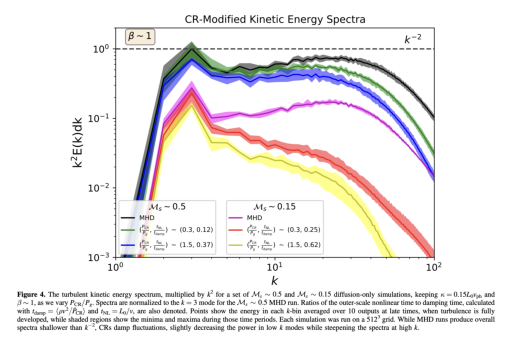

In [25]:
from PIL import Image
import matplotlib.pyplot as plt
image_path = "figures/BustardOh2023_fig4.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

The above figure from Bustard and Oh 2023 shows kinetic energy spectra for two different turbulent Mach numbers ($\mathcal{M} \sim 0.15$ and $\mathcal{M} \sim 0.5$) and different ratios of cosmic ray pressure $P_{\rm CR}$ to gas pressure $P_{\rm g}$. Black and magenta curves are for the no-CR (MHD) cases. As $P_{\rm CR}/P_{\rm g}$ increases, cosmic rays damp high-k fluctuations more and more. The yellow curve, which we think has parameters quite appropriate for the circumgalactic medium of Milky Way-mass galaxies, shows the most dramatic change, suggesting that turbulence may look very different in the diffuse surroundings of galaxies compared to their interiors.

## Separating compressive and solenoidal motions -- Hodge-Helmholtz Decomposition

How cosmic rays impact turbulence goes beyond spectral changes. Cosmic rays also appear to impact the mixture of solenoidal and compressive motions, which in turn affects the shape of turbulent eddies at different scales (e.g. whether eddies are elongated along the magnetic field or isotropic with respect to it). 


In [27]:
# Hodge-Helmholtz decomposition of 3D velocity field into compressive and solenoidal components
# 
# Outline:
#	1. v(r) --> v(k) by taking a 3D FFT of velocity field v(r)
#	2. Find solenoidal component (k \cdot vsol(k) = 0) as:
#		For each i in 1 to 3:
#			visol(k) = sum(delta_ij - kikj/k^2)vj(k) for j = 1 to 3
#
# 	3. Find compressive component as vicomp(k) = vi(k) - visol(k)
#	4. Produce a power spectrum of each component, compare integrated power, etc.
#	5. (Optionally) Project back into physical space via inverse FFT


import yt
import numpy as np
import matplotlib.pyplot as plt
from yt.units.yt_array import YTQuantity
from yt.fields.api import ValidateParameter

def decompose(ds):
    # Calls FFT to do step 1
    # Does steps 2-4 for an individual snapshot and returns
    #	Vector of wavenumbers, total velocity power spectrum, solenoidal power spectrum, 
    #   compressive power spectrum
   

    # Step 1 ..........................................................................

    # a FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this.
    max_level = ds.index.max_level

    low = ds.domain_left_edge
    dims = ds.domain_dimensions*int(1.0)
    nx, ny, nz = dims

    
    # FFT of v_x, v_y, v_z
    vx, v_k_x = fft_comp(ds, ("gas","velocity_x"), max_level, low, dims)
    vy, v_k_y = fft_comp(ds, ("gas","velocity_y"), max_level, low, dims)
    vz, v_k_z = fft_comp(ds, ("gas","velocity_z"), max_level, low, dims)
 

    print("Shapes of v_k componennts: ")
    print(v_k_x.shape)   
    print(v_k_y.shape)   
    print(v_k_z.shape)
   
    # wavenumbers
    #kx = np.fft.rfftfreq(nx).reshape(nx,1,1)
    #ky = np.fft.rfftfreq(ny).reshape(ny,1,1)
    #kz = np.fft.rfftfreq(nz)
    kx = np.fft.fftfreq(nx)
    ky = np.fft.fftfreq(ny)
    kz = np.fft.fftfreq(nz)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k2 = kx3d**2 + ky3d**2 + kz3d**2
    k2[0,0,0] = 1. # get rid of infinite scale
   

    # new
    div_Vf_k = (v_k_x * kx3d + v_k_y * ky3d + v_k_z * kz3d)
    v_comp_overk = div_Vf_k / k2
    
    # Compressive components
    v_comp_x = np.fft.ifftn(v_comp_overk * kx3d)
    v_comp_y = np.fft.ifftn(v_comp_overk * ky3d)
    v_comp_z = np.fft.ifftn(v_comp_overk * kz3d)
    
    # Solenoidal components
    v_sol_x = np.fft.ifftn(v_k_x - (v_comp_overk * kx3d))
    v_sol_y = np.fft.ifftn(v_k_y - (v_comp_overk * ky3d))
    v_sol_z = np.fft.ifftn(v_k_z - (v_comp_overk * kz3d))

    return vx, vy, vz, v_comp_x, v_comp_y, v_comp_z, v_sol_x, v_sol_y, v_sol_z

# Calculates the Fourier transform of the velocity
def fft_comp(ds, iu, level, low, delta ):

    cube = ds.covering_grid(level, left_edge=low,
                            dims=delta,
                            fields=[iu])

    u = cube[iu].d

    # the first half of the axes -- that's what we keep.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.

    ru = np.fft.fftn(u) # computes 3D FFT over all axes
    return u, ru # velocity, fourier component of velocity  


def create_spectra(ds,v_sol_x, v_sol_y, v_sol_z, v_comp_x, v_comp_y, v_comp_z):

    # Only relevant if we have non-uniform resolution
    max_level = ds.index.max_level

    low = ds.domain_left_edge

    # Calculate dimensions of simulation domain in each direction
    dims = ds.domain_dimensions*int(1.0)
    nx, ny, nz = dims

    # Arrays to hold the Fourier power total, in solenoidal motions, 
    # and in compressive motions
    Kk = np.zeros( (nx//2+1, ny//2+1, nz//2+1))
    Kk_sol = np.zeros( (nx//2+1, ny//2+1, nz//2+1))
    Kk_comp = np.zeros( (nx//2+1, ny//2+1, nz//2+1))
    
    # Loop over velocities in x, y, z directions and calculate Fourier power
    for vel in [("gas","velocity_x"), ("gas","velocity_y"), ("gas","velocity_z")]:
    	Kk += fft_comp_power(ds, vel, max_level, low, dims)
    
    for vel in [v_sol_x, v_sol_y, v_sol_z]:
        ru = np.fft.fftn(vel)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
        ru = 8.0*ru/(nx*ny*nz)
        Kk_sol += np.abs(ru)**2.0
    
    for vel in [v_comp_x, v_comp_y, v_comp_z]:
    	ru = np.fft.fftn(vel)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    	ru = 8.0*ru/(nx*ny*nz)
    	Kk_comp += np.abs(ru)**2.0


    # wavenumbers
    L = (ds.domain_right_edge - ds.domain_left_edge).d

    kx = np.fft.rfftfreq(nx)*nx/L[0]
    ky = np.fft.rfftfreq(ny)*ny/L[1]
    kz = np.fft.rfftfreq(nz)*nz/L[2]

    # physical limits to the wavenumbers
    kmin = np.min(1.0/L)
    kmax = np.min(0.5*dims/L)

    kbins = np.arange(kmin, kmax, kmin)
    N = len(kbins)

    # bin the Fourier KE into radial kbins
    kx3d, ky3d, kz3d = np.meshgrid(kx, ky, kz, indexing="ij")
    k = np.sqrt(kx3d**2 + ky3d**2 + kz3d**2)

    whichbin = np.digitize(k.flat, kbins)
    ncount = np.bincount(whichbin)
    
    E_spectrum = np.zeros(len(ncount)-1)
    E_spectrum_sol = np.zeros(len(ncount)-1)
    E_spectrum_comp = np.zeros(len(ncount)-1)

    for n in range(0,len(ncount)-1):
        E_spectrum[n] = np.sum(Kk.flat[whichbin==n])
        E_spectrum_sol[n] = np.sum(Kk_sol.flat[whichbin==n])
        E_spectrum_comp[n] = np.sum(Kk_comp.flat[whichbin==n])

    k = kbins[0:N]
    E_spectrum = E_spectrum[0:N]
    E_spectrum_sol = E_spectrum_sol[0:N]
    E_spectrum_comp = E_spectrum_comp[0:N]


    return k, E_spectrum, E_spectrum_sol, E_spectrum_comp

def fft_comp_power(ds, iu, level, low, delta ):
    # FFT operates on uniformly gridded data.  We'll use the yt
    # covering grid for this in general, which allows this script to run on 
    # simulation grids with non-uniform resolution. In this specific application,
    # our grid is already uniform so this next line is overkill.
    cube = ds.covering_grid(level, left_edge=low,
                            dims=delta,
                            fields=[iu])

    u = cube[iu].d

    nx, ny, nz = u.shape

    # We keep just the first half of the axes in each direction.  Our
    # normalization has an '8' to account for this clipping to one
    # octant.
    ru = np.fft.fftn(u)[0:nx//2+1,0:ny//2+1,0:nz//2+1]
    ru = 8.0*ru/(nx*ny*nz)

    return np.abs(ru)**2  # absolute value and square to get the power

We now have all the helper functions to decompose the velocity field into solenoidal and compressive components. From there, we can plot the power spectra in each component and compare how different CR transport models affect both the total ratio of compressive to solenoidal power and the mixture of components as a function of scale. 

Because recreating the results of the paper involves loading and decomposing many files totaling 10s-100s of GBs, I've commented out the below script but left the file_path and files there to be modified. 

In [28]:
"""
file_path = "../"
files = "cr.out1.0004*"

ts = yt.DatasetSeries(file_path+files)
vtot_all_times = np.zeros(255)
vsol_all_times = np.zeros(255)
vcomp_all_times = np.zeros(255)

for ds in ts:
    dd = ds.all_data()

    # Decompose and return k and spectra for v_tot, v_sol, v_comp
    vx, vy, vz, v_comp_x, v_comp_y, v_comp_z, v_sol1_x, v_sol1_y, v_sol1_z = decompose(ds)

    v_sol_x = vx - v_comp_x
    v_sol_y = vy - v_comp_y
    v_sol_z = vz - v_comp_z

    print("Comparing v_sol......")
    print("From function: ")
    print(v_sol1_x)
    print("From restructured compressive component: ")
    print(v_sol_x)


    power_ratio = (v_sol_x.var() + v_sol_y.var() + v_sol_z.var())/(v_comp_x.var() + v_comp_y.var() + v_comp_z.var())
    #power_ratio = (v_sol_x.mean()**2.0 + v_sol_y.mean() + v_sol_z.mean()**2.0)/(v_comp_x.mean()**2.0 + v_comp_y.mean()**2.0 + v_comp_z.mean()**2.0)
    
    print("Variance in each component")
    print('Solenoidal x, y, z: ' + str(v_sol_x.var()) + ", " + str(v_sol_y.var()) + ", " + str(v_sol_z.var()))
    print('Compressive x, y, z: ' + str(v_comp_x.var()) + ", " + str(v_comp_y.var()) + ", " + str(v_comp_z.var()))
    
    print("Average squared in each component")
    print('Solenoidal x, y, z: ' + str(v_sol_x.mean()**2.0) + ", " + str(v_sol_y.mean()**2.0) + ", " + str(v_sol_z.mean()**2.0))
    print('Compressive x, y, z: ' + str(v_comp_x.mean()**2.0) + ", " + str(v_comp_y.mean()**2.0) + ", " + str(v_comp_z.mean()**2.0))
 
    print("Ratio of solenoidal to compressive power: " + str(power_ratio))  

    # Calculate power spectra of total, solenoidal, and compressive kinetic energy components
    kvec, tot_KE_spec, sol_KE_spec, comp_KE_spec = create_spectra(ds, v_sol_x, v_sol_y, v_sol_z, v_comp_x, v_comp_y, v_comp_z)

    # Stack together different time snapshots to later do time-series analysis
    vtot_all_times = np.vstack([vtot_all_times, tot_KE_spec])
    vsol_all_times = np.vstack([vsol_all_times, sol_KE_spec])
    vcomp_all_times = np.vstack([vcomp_all_times, comp_KE_spec])


# Space for time-series analysis -- i.e. averaging over many snapshots, etc.

#vtot_all_times = vtot_all_times[1:8,:]  # last few rows (times) of spectrum array
#vsol_all_times = vsol_all_times[1:8,:]  # last few rows (times) of spectrum array
#vcomp_all_times = vcomp_all_times[1:8,:]  # last few rows (times) of spectrum array

# take mean, min, max over time (axis = 0)
avg_tot = np.mean(vtot_all_times,axis = 0)
mina_tot = np.min(vtot_all_times,axis = 0)
maxa_tot = np.max(vtot_all_times,axis = 0)

avg_sol = np.mean(vsol_all_times,axis = 0)
mina_sol = np.min(vsol_all_times,axis = 0)
maxa_sol = np.max(vsol_all_times,axis = 0)

avg_comp = np.mean(vcomp_all_times,axis = 0)
mina_comp = np.min(vcomp_all_times,axis = 0)
maxa_comp = np.max(vcomp_all_times,axis = 0)

k = kvec[0:len(avg_tot)]

print("Plotting average spectra (with min and max) over several snapshots: ")

# normalize spectra by average value of total velocity spectrum at 3rd mode
norma = avg_tot[2]*k[2]**2

# Plot spectra together
# (Optional) Uncomment "fill_between" lines to show a shaded region between min and max power for each line
plt.loglog((k), avg_tot*(k**2)/norma, 'ko-',label=r"Total (Compressive + Solenoidal)")
#plt.fill_between((k), mina_tot*(k**2), maxa_tot*(k**2), facecolor='black', alpha=0.5)
plt.loglog((k), avg_sol*(k**2)/norma, 'bo-',label=r"Solenoidal")
#plt.fill_between((k), mina_sol*(k**2), maxa_sol*(k**2), facecolor='blue', alpha=0.5)
plt.loglog((k), avg_comp*(k**2)/norma, 'go-',label=r"Compressive")
#plt.fill_between((k), mina_comp*(k**2), maxa_comp*(k**2), facecolor='green', alpha=0.5)
plt.ylim(1E-4,5E0)
#plt.xlim(3E-2,2E0)
plt.xlim(0.5,50)
plt.xlabel(r"$k$",fontsize=18)
plt.ylabel(r"Power Spectra x k^2",fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("HH_diff_beta10.pdf")
plt.close()

print("Total Values: ")
print(avg_tot)
print(mina_tot)
print(maxa_tot)
print("Solenoidal Values: ")
print(avg_sol)
print(mina_sol)
print(maxa_sol)
print("Compressive Values: ")
print(avg_comp)
print(mina_comp)
print(maxa_comp)
print("k: ")
print(k)
"""

'\nfile_path = "../"\nfiles = "cr.out1.0004*"\n\nts = yt.DatasetSeries(file_path+files)\nvtot_all_times = np.zeros(255)\nvsol_all_times = np.zeros(255)\nvcomp_all_times = np.zeros(255)\n\nfor ds in ts:\n    dd = ds.all_data()\n\n    # Decompose and return k and spectra for v_tot, v_sol, v_comp\n    vx, vy, vz, v_comp_x, v_comp_y, v_comp_z, v_sol1_x, v_sol1_y, v_sol1_z = decompose(ds)\n\n    v_sol_x = vx - v_comp_x\n    v_sol_y = vy - v_comp_y\n    v_sol_z = vz - v_comp_z\n\n    print("Comparing v_sol......")\n    print("From function: ")\n    print(v_sol1_x)\n    print("From restructured compressive component: ")\n    print(v_sol_x)\n\n\n    power_ratio = (v_sol_x.var() + v_sol_y.var() + v_sol_z.var())/(v_comp_x.var() + v_comp_y.var() + v_comp_z.var())\n    #power_ratio = (v_sol_x.mean()**2.0 + v_sol_y.mean() + v_sol_z.mean()**2.0)/(v_comp_x.mean()**2.0 + v_comp_y.mean()**2.0 + v_comp_z.mean()**2.0)\n    \n    print("Variance in each component")\n    print(\'Solenoidal x, y, z: \' + st

Attached is a figure from Bustard and Oh 2023 showing the outcome for different CR transport models. 

(-0.5, 2531.5, 1049.5, -0.5)

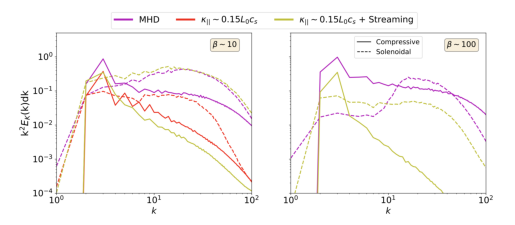

In [29]:
image_path = "figures/BustardOh2023_fig10.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

One can see how solenoidal energy $E_{\rm sol}$ (dashed lines) and compressive energy $E_{\rm comp}$ (solid lines) vary as a function of scale, with solenoidal motions generally being most important (or even dominant) at small scales / high-k. This depends on transport, however. Especially for $\beta \sim 100$ (right panel), CR streaming leads to a much larger ratio of $E_{\rm sol}/E_{\rm comp}$ compared to the no-CR MHD case, particularly at small scales. 

While a more definite conclusion awaits future simulations and analysis, we speculate that CR damping predominantly acts on compressive motions, but since compressions combine with magnetic tension to drive solenoidal motions (see e.g. Lim et al. 2020), CR damping ultimately affects the solenoidal energy too. That it generally leads to more solenoidal power than compressive power indicates that CRs mainly damp compressions; this "divergence cleaning" of the velocity field is quite interesting and deserves additional follow-up with simulations employing a mixture of solenoidal and compressive driving from the start, rather than solely compressive driving. For instance, we show in our paper that the anisotropy of turbulent eddies, which depends on the solenoidal vs compressive ratio, is affected by CRs; when CR damping is strong, eddies become more elongated along the mean magnetic field direction, which has interesting implications for cosmic ray scattering by turbulent eddies. This is way beyond the scope of this notebook; read about it more in the paper! 

## Broader turbulence statistics
We've seen a few different ways that cosmic rays affect turbulence, particularly the kinetic energy spectra and the mixture of solenoidal vs compressive motions. How about something more basic, like the probability distribution function of CR pressure, gas density, and velocity? Below, we won't plot any PDFs (though this is pretty easy to do with yt). Instead, we'll quantify three summary statistics probing the width of the PDFs: $\delta v /v$, $\delta \rho /\rho$, and $\delta P_{\rm CR} / P_{\rm CR}$. Here, the numerator is the standard deviation of log10 of the field, while the denominator is the average of log10 of that field over the whole simulation box. We do log10 because turbulent PDFs are generally lognormal, and this calculation conforms with previous work. 

In [30]:
def quantify_std_dev(file_path,files):

  devdensArr = []
  devvelArr = []
  devEcArr = []

  ts = yt.DatasetSeries(file_path+files,parallel=False)

  for ds in ts.piter():
    dd = ds.all_data()

    # Calculate average field quantities
    avg_density = dd.quantities.weighted_average_quantity("density",weight="ones")
    avg_vel = dd.quantities.weighted_average_quantity("velocity_magnitude",weight="ones")
    avg_Ec = dd.quantities.weighted_average_quantity("Ec",weight="ones")

    # Since compressive turbulence leads to lognormal distributions (usually), 
    # we move this calculation into log space, i.e. we'll take the log10(density / average density)
    # and then calculate it's standard deviation

    def density_log(field, data):
      return np.log(data['density']/avg_density)

    ds.add_field(('gas', u'density_log'), function = density_log, units="")

    def vel_log(field, data):
      return np.log(data['velocity_magnitude']/avg_vel)

    ds.add_field(('gas', u'vel_log'), function = vel_log, units="")

    def Ec_log(field, data):
      return np.log(data['Ec']/avg_Ec)

    ds.add_field(('gas', u'Ec_log'), function = Ec_log, units="")

    # Take the standard deviation, which in yt lingo is very incorrectly called the "variance"
    stddev_density, avg_density = dd.quantities.weighted_variance("density_log",weight="ones")
    stddev_vel,avg_vel = dd.quantities.weighted_variance("vel_log",weight="ones")
    stddev_Ec,avg_Ec = dd.quantities.weighted_variance("Ec_log",weight="ones")
    devdensArr.append(stddev_density)
    devvelArr.append(stddev_vel)
    devEcArr.append(stddev_Ec)

    print("delta rho ")
    print(devdensArr)
    print("delta v ")
    print(devvelArr)
    print("delta Ec ")
    print(devEcArr)

Running the above code snippet on a series of simulation volumes with varying CR diffusivity and varying $P_{\rm CR}/P_{\rm g}$ yields the figure below. In canonical MHD turbulence, there's a rough equivalence between the plotted quantities: $\delta v /v \sim \delta \rho /\rho$. With CRs, that is no longer true. Especially as CR content increases and CR damping becomes more important around $P_{\rm CR}/P_{\rm g} > 1$, fluctuating quantities deviate significantly. 

(-0.5, 1923.5, 1005.5, -0.5)

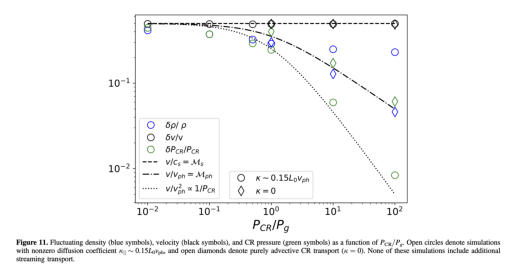

In [31]:
image_path = "figures/BustardOh2023_fig11.png"
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')

As shown above, the canonical $\delta v /v \sim \delta \rho /\rho$ relationship is broken in the presence of cosmic rays, with a dependency on $P_{CR}/P_{g}$, and cosmic ray fluctuations also have a dependency. Additionally, these fluctuations depend as well on cosmic ray transport: when cosmic ray diffusion hits a sweet-spot value, it damps fluctuations, and this damping is imprinted on the gas density (low $\delta \rho /\rho$). These imprints differ when cosmic rays do not diffuse, or when diffusion is very fast (not shown). 